# Notebook 03: Temporal Degradation Patterns
## Epoch 003: Exploratory Data Analysis

This notebook analyzes how sensor values change over time and identifies degradation patterns as engines approach failure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path

sys.path.insert(0, '/mnt/code/src')
from predictive_maintenance.data_utils import load_turbofan_data, calculate_rul

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

In [2]:
# Load data
DATA_PATH = Path('/mnt/data/Preventative-Maintainance-Example/epoch002-data-wrangling')
df = load_turbofan_data(DATA_PATH / 'fd001_train.parquet')
df = calculate_rul(df)
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]

## 1. Sample Engine Lifecycles

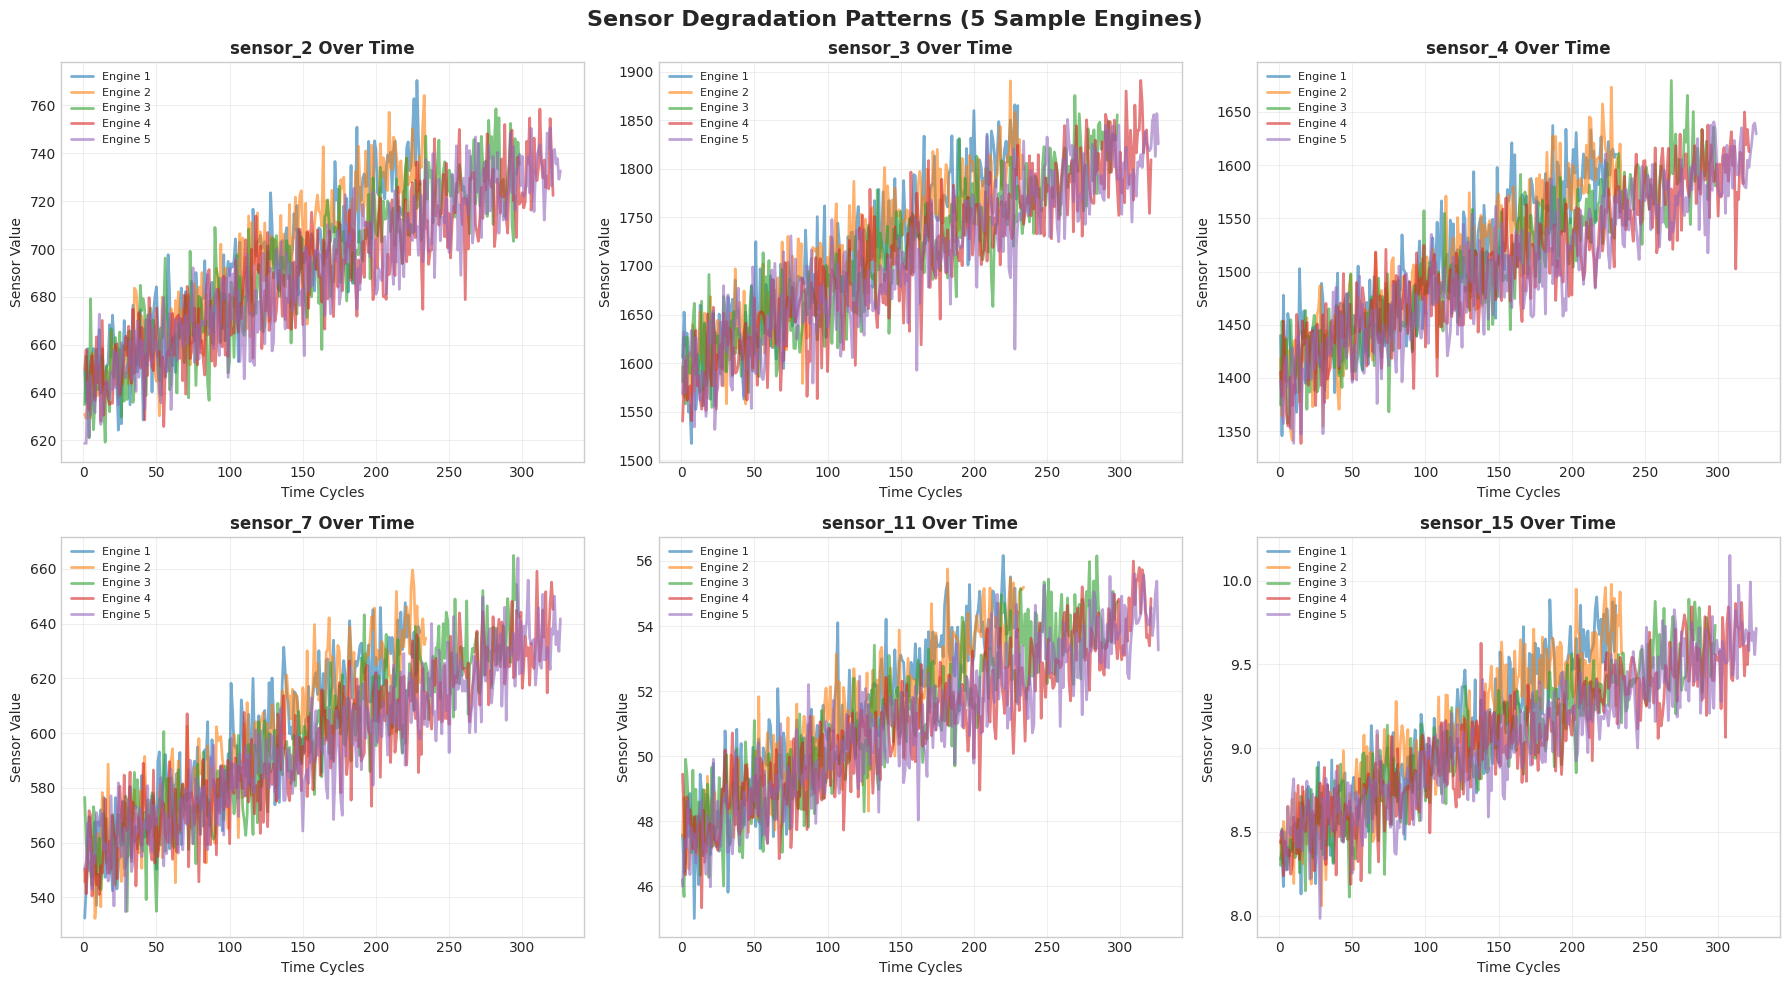

In [3]:
# Select 5 sample engines
sample_engines = df['unit_id'].unique()[:5]

# Plot sensor trends for selected sensors
selected_sensors = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_11', 'sensor_15']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(selected_sensors):
    for engine_id in sample_engines:
        engine_data = df[df['unit_id'] == engine_id].sort_values('time_cycles')
        axes[idx].plot(engine_data['time_cycles'], engine_data[sensor],
                      alpha=0.6, label=f'Engine {engine_id}', linewidth=2)
    
    axes[idx].set_title(f'{sensor} Over Time', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Time Cycles')
    axes[idx].set_ylabel('Sensor Value')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Sensor Degradation Patterns (5 Sample Engines)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/03_temporal_patterns.png', 
            dpi=150, bbox_inches='tight')
plt.show()

## 2. Average Sensor Trends (All Engines)

/tmp/ipykernel_8956/1651925934.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lifecycle_trends = df.groupby('lifecycle_bin')[selected_sensors].mean()


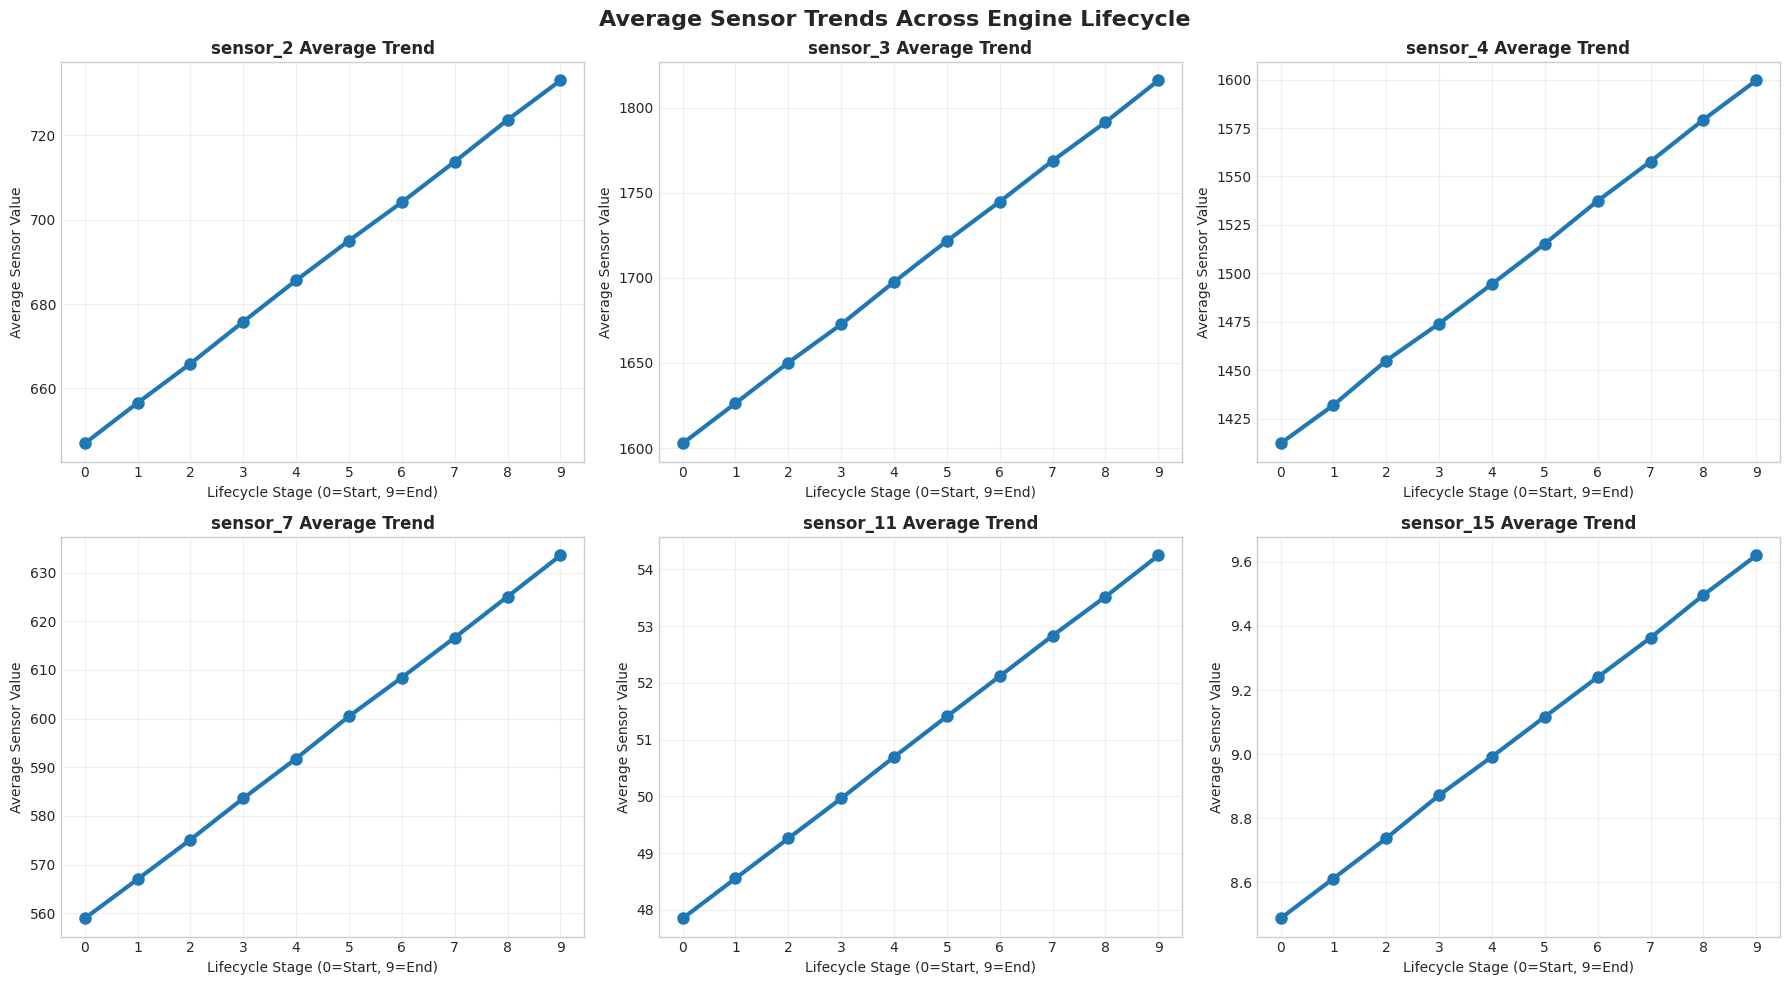

In [4]:
# Normalize time for all engines (as percentage of lifetime)
df['lifetime_pct'] = (df['time_cycles'] / df.groupby('unit_id')['time_cycles'].transform('max')) * 100

# Bin by lifecycle percentage
df['lifecycle_bin'] = pd.cut(df['lifetime_pct'], bins=10, labels=range(10))

# Calculate mean for each lifecycle bin
lifecycle_trends = df.groupby('lifecycle_bin')[selected_sensors].mean()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(selected_sensors):
    axes[idx].plot(range(10), lifecycle_trends[sensor], marker='o', linewidth=3, markersize=8)
    axes[idx].set_title(f'{sensor} Average Trend', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Lifecycle Stage (0=Start, 9=End)')
    axes[idx].set_ylabel('Average Sensor Value')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xticks(range(10))

plt.suptitle('Average Sensor Trends Across Engine Lifecycle', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/03_average_trends.png', 
            dpi=150, bbox_inches='tight')
plt.show()

## 3. RUL-Based Analysis

/tmp/ipykernel_8956/1982645530.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rul_comparison = df.groupby('rul_bin')[selected_sensors].mean()


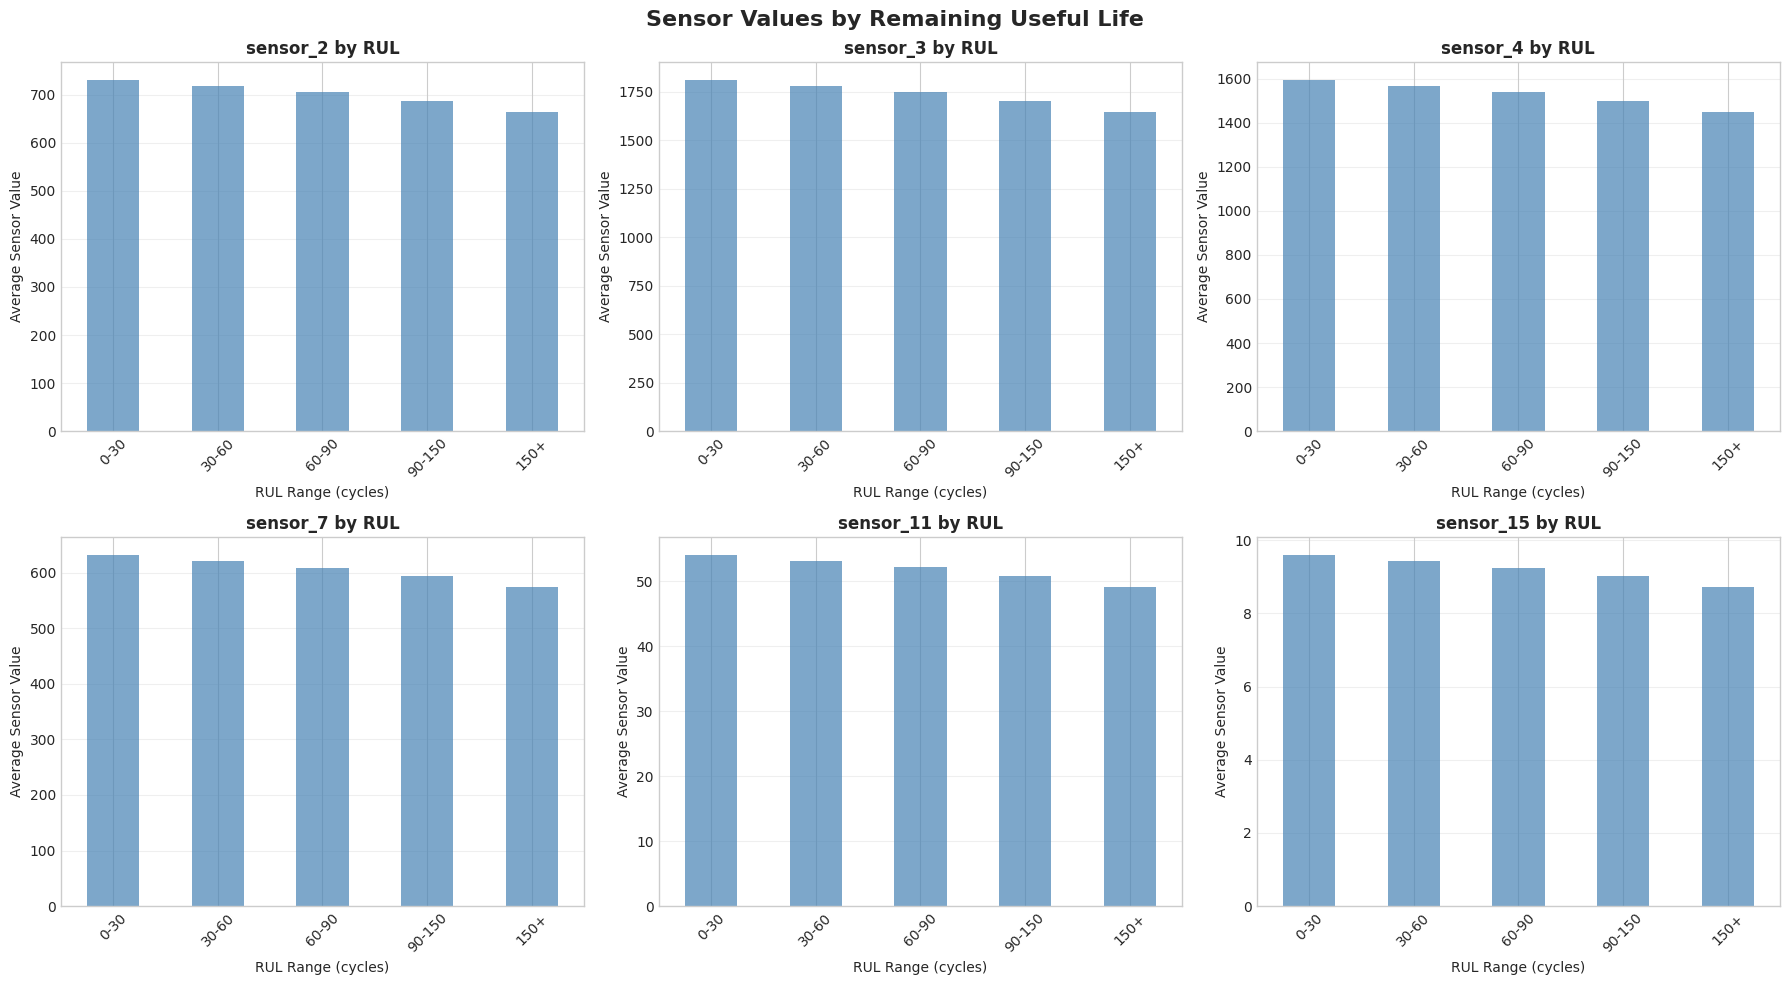

In [5]:
# Group by RUL bins
df['rul_bin'] = pd.cut(df['RUL'], bins=[0, 30, 60, 90, 150, 400], 
                        labels=['0-30', '30-60', '60-90', '90-150', '150+'])

# Compare sensor values at different RUL stages
rul_comparison = df.groupby('rul_bin')[selected_sensors].mean()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, sensor in enumerate(selected_sensors):
    rul_comparison[sensor].plot(kind='bar', ax=axes[idx], color='steelblue', alpha=0.7)
    axes[idx].set_title(f'{sensor} by RUL', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('RUL Range (cycles)')
    axes[idx].set_ylabel('Average Sensor Value')
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('Sensor Values by Remaining Useful Life', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('/mnt/artifacts/epoch003-exploratory-data-analysis/03_rul_based_trends.png', 
            dpi=150, bbox_inches='tight')
plt.show()

## 4. Summary

### Key Observations:

1. **Clear Degradation Patterns:** Most sensors show monotonic trends as engines approach failure
2. **Sensor-Specific Behaviors:** Some sensors increase over time, others decrease
3. **RUL Correlation:** Sensor values change systematically with remaining useful life
4. **Engine Variability:** Different engines show similar patterns but with different magnitudes

### Implications:
- Temporal features (rolling averages, trends) will be highly valuable
- Rate of change features can capture acceleration toward failure
- Different sensors provide complementary information about degradation